## Contenu: Visualisation de la production éolienne et solaire, Analyse des corrélations & Analyse des valeurs extrêmes

In [6]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
sns.set_theme()
import scipy.stats as stats
from scipy.stats import chi2_contingency
from scipy.stats import pearsonr
import statsmodels.api as sm
from statsmodels.formula.api import ols

#import des données de production & consommation par date et région
col_list = ["Région","Nature","Date","Date - Heure","Thermique (MW)","Nucléaire (MW)",
            "Eolien (MW)","Solaire (MW)","Hydraulique (MW)","Bioénergies (MW)", "Consommation (MW)"]
df = pd.read_csv(r"C:\Users\verre\Downloads\eco2mix-regional-cons-def.csv", sep = ";", usecols=col_list)

In [7]:
# Conversion des variables Date & Heure en format datetime
df["Date"] = pd.to_datetime(df["Date"])
df["Date - Heure"] = pd.to_datetime(df["Date - Heure"], utc = True)
# remettre les heures en CET (UTC + 01:00)
df["Date - Heure"] = df["Date - Heure"].dt.tz_convert(tz='CET')
# Ajout d'une colonne "Annee"
df["Annee"] = df["Date"].dt.year

## Visualisation de la production éolienne
### Production par filière en 2019

C:\Users\verre\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


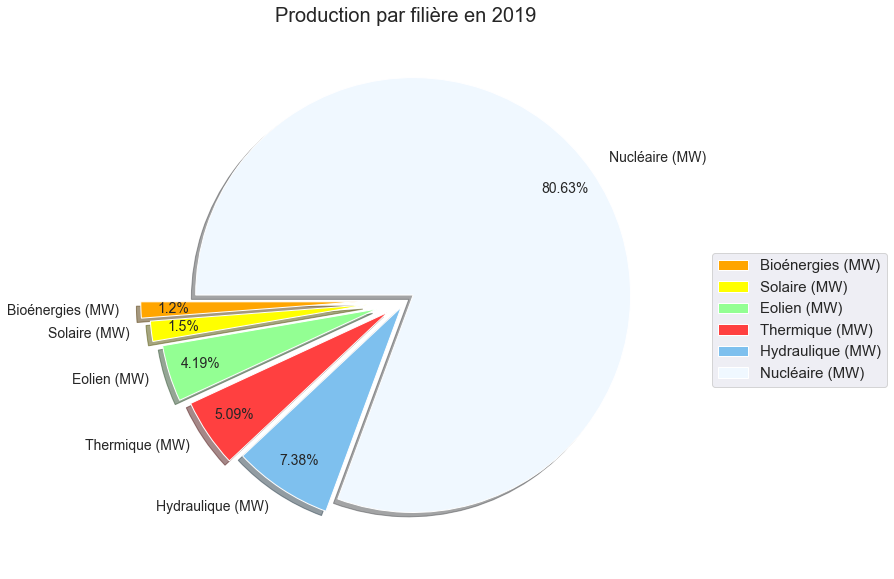

In [8]:
df_2019 = df.loc[df["Annee"] == 2019]
df_2019.drop(columns = ["Annee", "Consommation (MW)"], axis=1,inplace=True)
means = pd.DataFrame(df_2019.mean(axis=0, numeric_only=True).sort_values()).reset_index()

plt.figure(figsize = (10, 10))
plt.pie(x = means.iloc[ : , 1 ], labels = means.iloc[ : ,0 ],
            colors = ['#ffa500','#ffff00','#93FF93','#ff4040','#7ec0ee','#f0f8ff'],
           explode = [0.22, 0.18, 0.14, 0.1, 0.04, 0.04],
           autopct = lambda x: str(round(x, 2)) + '%',
           pctdistance = 0.85, labeldistance = 1.1, startangle=180,
            textprops={'fontsize': 14},
           shadow = True)
plt.title('Production par filière en 2019', fontsize = 20)
plt.legend(bbox_to_anchor = (1.05, 0.6), fontsize=15)
plt.savefig("Pictures/#01_-_Production_par_filiere_en_2019.png", dpi=150, bbox_inches='tight')
plt.show();

### Production éolienne par jour en 2019

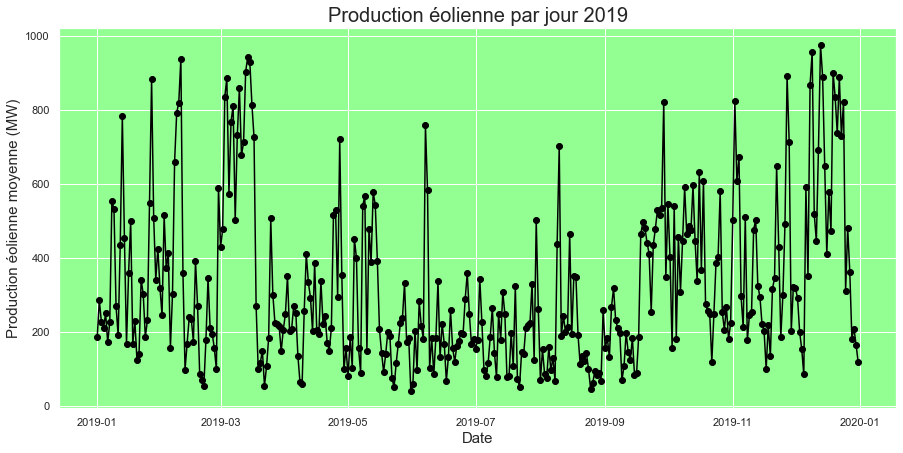

In [9]:
df_2019_mean = df_2019[["Date", "Eolien (MW)"]].groupby("Date").mean()
df_2019_mean["Date"] = df_2019_mean.index

fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(1, 1, 1)
ax.set_facecolor('#93FF93')
dates = df_2019_mean["Date"]
values = df_2019_mean["Eolien (MW)"]
plt.plot_date(mpl.dates.date2num(dates), values, linestyle='-', color='black')
plt.title('Production éolienne par jour 2019', fontsize = 20)
plt.xlabel('Date', size=15)
plt.ylabel('Production éolienne moyenne (MW)', size=15)
plt.savefig("Pictures/#02_-_Production_eolienne_par_jour_en_2019.png", dpi=150, bbox_inches='tight')
plt.show();

# on voit une très grande variation dans la production moyenne par demi-heure, entre 100 MW et 1000 MW
# en été il y a moins de variation, entre 100 et 400 MW en aout
# On peut en deduire une grande variation dans la puissance du vent d'un jour à l'autre
# & l'ajustement de la production en fonction de la demande

### Production eolienne moyenne par région en 2019 

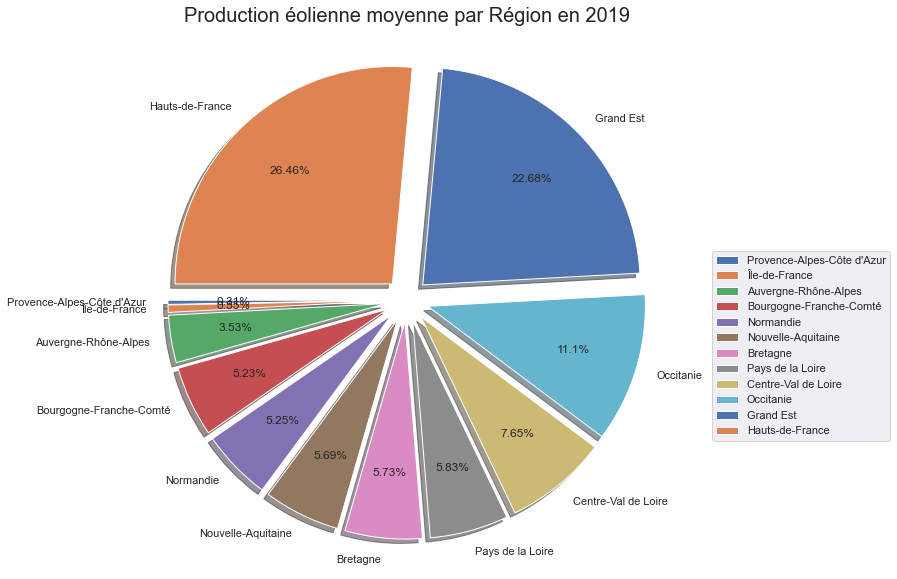

In [10]:
df_2019_region = df_2019[["Région","Eolien (MW)"]].groupby("Région").mean()
df_2019_region["Région"] = df_2019_region.index
df_2019_region.sort_values(by="Eolien (MW)",ascending=True, inplace = True)

plt.figure(figsize = (10, 10))
plt.pie(x = df_2019_region["Eolien (MW)"], labels = df_2019_region["Région"],
           explode = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,0.1, 0.1, 0.1, 0.1],
           autopct = lambda x: str(round(x, 2)) + '%',
           pctdistance = 0.7, labeldistance = 1.1, startangle=180,
           shadow = True)
plt.title('Production éolienne moyenne par Région en 2019', fontsize = 20)
plt.legend(bbox_to_anchor = (1.05, 0.6))
plt.savefig("Pictures/#03_-_Production_eolienne_moyenne_par_region_2019.png", dpi=150, bbox_inches='tight')
plt.show();

# on voit que presque 50% de la production moyenne vient de deux régions : Hauts de France & Grand Est

### Production eolienne 2015 - 2019 selon région

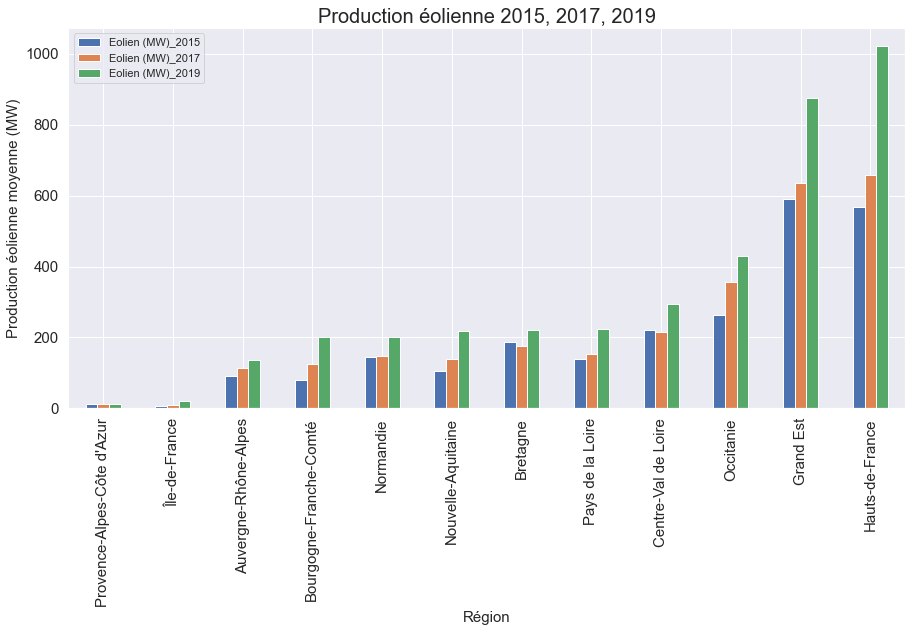

In [11]:
#Separation des données par année
df_2017 = df.loc[df["Annee"] == 2017]
df_2015 = df.loc[df["Annee"] == 2015]
# groupby : Région
df_2015_region = df_2015[["Région","Eolien (MW)"]].groupby("Région").mean()
df_2017_region = df_2017[["Région","Eolien (MW)"]].groupby("Région").mean()
df_regions = df_2019_region.drop("Région", axis = 1).merge(df_2017_region["Eolien (MW)"], left_index=True, right_index=True, 
                                                           suffixes=('_2019', '_2017'))
df_regions = df_regions.merge(df_2015_region["Eolien (MW)"], left_index=True, right_index=True)
df_regions.rename(columns = {'Eolien (MW)':'Eolien (MW)_2015'}, inplace = True)

df_regions[['Eolien (MW)_2015','Eolien (MW)_2017', 'Eolien (MW)_2019']].plot(kind='bar',figsize=(15,7), fontsize=15)
plt.title("Production éolienne 2015, 2017, 2019",fontsize=20)
plt.ylabel('Production éolienne moyenne (MW)', size=15)
plt.xlabel('Région', size=15)
plt.savefig("Pictures/#04_-_Production_eolienne_2015_2019_selon_region.png", dpi=150, bbox_inches='tight')
plt.show()

### Distribution des valeurs de production eolienne en 2019

In [12]:
df_2019["Eolien (MW)"].describe().round(2)
# la valeur max est très élévée par comparaison avec la moyenne & la quartile 75%
# la valeur min est negative, qui semble une valeur aberrante

count    210240.00
mean        321.69
std         503.81
min          -3.00
25%          38.00
50%         144.00
75%         387.00
max        3780.00
Name: Eolien (MW), dtype: float64

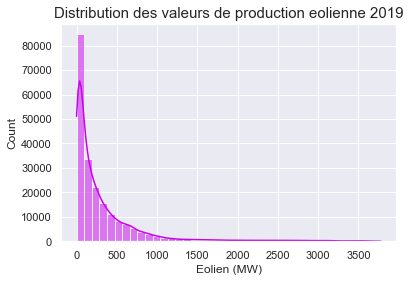

In [13]:
# Afficher la repartition de la variable "Eolien" en 2019
sns.histplot(df_2019["Eolien (MW)"], bins = 40, kde=True, color = '#c901ed')
plt.title('Distribution des valeurs de production eolienne 2019', fontsize=15)
plt.savefig("Pictures/#05_-_Distribution_production_eolienne_2019.png", dpi=150, bbox_inches='tight')
plt.show();
# La distribution est très desequilibrée : la grande majorité des valeurs sont moins de 200 MW, et
# il y a peu de valeurs > 1000 mais la distribution va jusqu'à 3780 MW 

## Analyse des corrélations
### Distribution de la variable "Vitesse du vent"

In [14]:
# import des données sur la vitesse du vent
meteo = pd.read_csv(r"C:\Users\verre\Downloads\meteo.csv", sep = ";")
meteo.drop("Code INSEE région", axis = 1, inplace = True)
meteo.describe().round(2)
# on note que la valeur max est très élévée par rapport au moyen et au quartile 75%
# il y a donc des valeurs un peu aberrantes, on peut eventuellement les exclure d'un modèle

,Vitesse du vent à 100m (m/s),Rayonnement solaire global (W/m2)
count,209351.00,209351.00
mean,5.79,158.06
std,1.82,216.10
min,1.38,0.00
25%,4.48,0.00
50%,5.56,31.45
75%,6.84,279.54
max,16.55,897.99


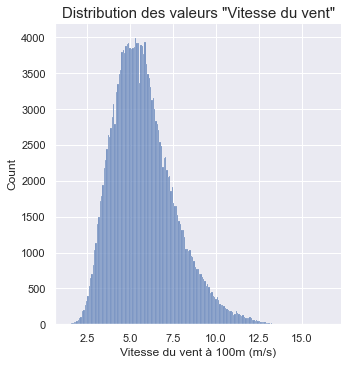

In [15]:
# Quelle est la distribution de la variable "Vitesse du vent"?
sns.displot(meteo['Vitesse du vent à 100m (m/s)'])
plt.title('Distribution des valeurs "Vitesse du vent"', fontsize=15)
plt.savefig("Pictures/#06_-_Distribution_vitesse_vent.png", dpi=150, bbox_inches='tight')
plt.show();

In [16]:
# Fusion des données sur les colonnes Date-Heure, & Région:

# changer le nom de la colonne "Date" du "meteo" à "Date - Heure"
meteo.rename(columns = {'Date':'Date - Heure'}, inplace = True)
# conversion des colonnes Date_Heure au type Datetime
meteo["Date - Heure"] = pd.to_datetime(meteo["Date - Heure"], utc=True)
# remettre les heures en CET (UTC + 01:00)
meteo["Date - Heure"] = meteo["Date - Heure"].dt.tz_convert(tz='CET')
# Analyse de la colonne "Nature", qui n'existe pas dans le dataframe "meteo"
print(df['Nature'].unique())

['Données définitives' 'Données consolidées']


In [17]:
# Analyse de la colonne "Nature" : quelles données sont définitives?
pd.crosstab(df['Nature'], df['Annee'])
# toutes les données du 2013 à 2019 sont "définitives"
# toutes les données du 2020 & 2021 sont "consolidées"

Annee,2013,2014,2015,2016,2017,2018,2019,2020,2021
Nature,,,,,,,,,
Données consolidées,0,0,0,0,0,0,0,210816,86976
Données définitives,210240,210240,210240,210816,210240,210240,210240,0,0


In [18]:
# separation des données définitives & consolidées dans 2 Dataframes
df_def = df.loc[(df["Annee"] != 2021) & (df["Annee"] != 2020)]
df_con = df.loc[(df["Annee"] == 2021) | (df["Annee"] == 2020)]
meteo["Annee"] = meteo["Date - Heure"].dt.year
meteo_def = meteo.loc[(meteo["Annee"] != 2021) & (meteo["Annee"] != 2020)]
meteo_con = meteo.loc[(meteo["Annee"] == 2021) | (meteo["Annee"] == 2020)]
print(meteo_def['Annee'].unique())
print(meteo_con['Annee'].unique())
# on note que les données meteo commencent en 2016

[2018 2019 2016 2017]
[2020 2021]


In [19]:
# Fusion des données définitives (2016 - 2019) et données consolidées (2020 - 2021)
data_2016_2019 = pd.merge(df_def, meteo_def, on=["Date - Heure", "Région"])
data_2020_2021 = pd.merge(df_con, meteo_con, on=["Date - Heure", "Région"])
# supprimer la colonne redondante 'Annee y'
data_2016_2019.drop('Annee_y', axis=1, inplace=True)
data_2020_2021.drop('Annee_y', axis=1, inplace=True)

data_2016_2019.rename(columns = {'Annee_x':'Annee'}, inplace = True)
data_2020_2021.rename(columns = {'Annee_x':'Annee'}, inplace = True)

# Ajout des colonnes "Month" & "Hour" qui seront utile ensuite pour la modelisation
data_2016_2019["Month"] = data_2016_2019["Date - Heure"].dt.month
data_2016_2019["Hour"] = data_2016_2019["Date - Heure"].dt.hour
data_2016_2019['Day'] = data_2016_2019['Date - Heure'].dt.day_name()

data_2020_2021["Month"] = data_2020_2021["Date - Heure"].dt.month
data_2020_2021["Hour"] = data_2020_2021["Date - Heure"].dt.hour
data_2020_2021['Day'] = data_2020_2021['Date - Heure'].dt.day_name()

# enregister les 2 dataframes:
data_2016_2019.to_csv('data_2016_2019.csv', index=False)
data_2020_2021.to_csv('data_2020_2021.csv', index=False)

### Production eolienne / jour de la semaine

In [20]:
# on prend une seule région : Hauts de France
HDF = data_2016_2019[['Région','Consommation (MW)','Eolien (MW)','Vitesse du vent à 100m (m/s)',
                      'Annee', 'Month', 'Hour','Day']].loc[(data_2016_2019["Région"] == "Hauts-de-France")]

# analyse de la variance (ANOVA) sur Production Eolienne & "Day"
prod = HDF["Eolien (MW)"]
model = ols('prod ~ C(Day)', data=HDF).fit()
sm.stats.anova_lm(model, typ=2)

# la p-value (PR(>F)) est inférieur à 5% : on rejette l'hypothèse selon laquelle "Day" n'influe pas sur production éolienne.
# cependant, je ne suis pas sûr que l'utilisation de ce test soit valide, car la variable "Eolien (MW)" n'a pas de 
# distribution normale (voir ref : https://www.pythonfordatascience.org/parametric-assumptions-python/)

,sum_sq,df,F,PR(>F)
C(Day),2.821230e+07,6.0,8.226294,6.606271e-09
Residual,6.696725e+09,11716.0,NaN,NaN


In [21]:
# on va grouper la production en quintiles afin de visualiser les correlations & d'utiliser le test χ2
HDF["Eolien_groups"] = pd.qcut(x = HDF['Eolien (MW)'], q=5,
                  labels = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5'])

In [22]:
results, bins_edges = pd.qcut(x = HDF['Eolien (MW)'], q=5, retbins=True)
print(bins_edges)
# Les groupes sont : 
# 3 - 154 MW / 154 - 360 MW / 360 - 682 MW / 682 - 1281 MW / 1281 - 3732 MW

[3.000e+00 1.540e+02 3.600e+02 6.820e+02 1.281e+03 3.732e+03]


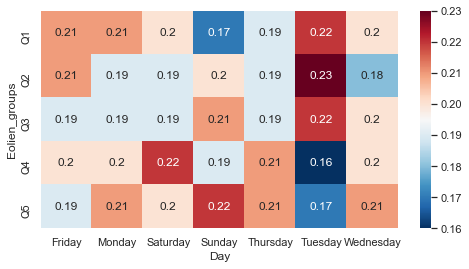

In [23]:
# Est-ce qu'il y a une difference visible entre les jours ouvrés et les weekends?
table = pd.crosstab(HDF['Eolien_groups'], 
            HDF['Day'],  normalize = 1).round(2)
plt.figure(figsize=(8,4))
sns.heatmap(table, annot=True, cmap='RdBu_r')
plt.savefig("Pictures/#07_-_Crosstab_prod_jour.png", dpi=150, bbox_inches='tight')
plt.show()
# on ne voit pas de tendance : est-ce que ça signifie que la demande n'est pas moindre le weekend?
# ou que la production eolienne n'est pas ajustée en conséquence d'une difference de demande les weekends?

In [24]:
# on va essayer un test χ2 pour confirmer si ces 2 variables sont indépendantes
table = pd.crosstab(HDF['Eolien_groups'], 
            HDF['Day'])
resultats_test = chi2_contingency(table)
statistique = resultats_test[0]
p_valeur = resultats_test[1]
degre_liberte = resultats_test[2]
print(statistique, p_valeur,degre_liberte)
# p-value < 5% : on rejette l'hypothèse "les variables sont indépendantes"

64.15375917117434 1.6185592853525676e-05 24


In [25]:
# on va mesurer le niveau de corrélation (V Cramer)
X2 = stats.chi2_contingency(table)[0]
n = np.sum(table)
minDim = min(table.shape)-1
# calculation de V Cramer
V = np.sqrt((X2/n) / minDim)
print(V.mean())
# V Cramer = 0.1 indique une correlation faible

0.09786138433516278


### Production eolienne  / mois

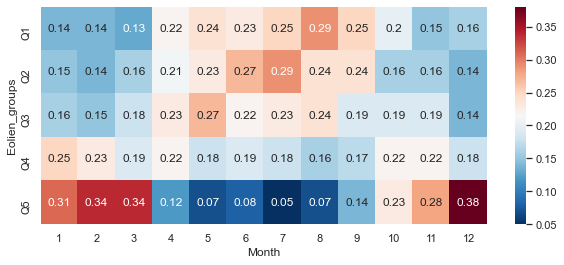

In [26]:
# Est-ce qu'il y a une difference visible entre les mois?
table2 = pd.crosstab(HDF['Eolien_groups'], 
            HDF['Month'],  normalize = 1).round(2)
plt.figure(figsize=(10,4))
sns.heatmap(table2, annot=True, cmap='RdBu_r')
plt.savefig("Pictures/#08_-_Crosstab_prod_mois.png", dpi=150, bbox_inches='tight')
plt.show()
# ici les differences sont claires: en hiver 30-40% des valeurs sont Q5 (1396-3421 MW) & Q1, Q2, Q3 (0-761 MW) répresentent 
# chacun environ 15% / entre mai & aout moins de 10% des valeurs sont Q5 et Q1, Q2, Q3 répresentent chacun environ 25% 

In [27]:
# on fait le test χ2 pour les variables Month & Eolien Groups:
table2 = pd.crosstab(HDF['Eolien_groups'], 
            HDF['Month'])
resultats_test2 = chi2_contingency(table2)
statistique2 = resultats_test2[0]
p_valeur2 = resultats_test2[1]
degre_liberte2 = resultats_test2[2]
print(statistique2, p_valeur2,degre_liberte2)
# p-value zero: on rejette l'hypothèse "les variables sont indépendantes"

1283.3555757536983 3.824881549647035e-240 44


In [28]:
# V Cramer
X2 = stats.chi2_contingency(table2)[0]
n = np.sum(table2)
minDim = min(table2.shape)-1
V = np.sqrt((X2/n) / minDim)
print(V.mean())
# V Cramer ~0.57 indique une correlation significative

0.5732846729140145


### Production eolienne / heure?

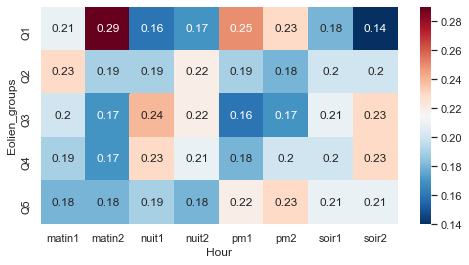

In [29]:
# on va grouper les heures en 8 groupes :
HDF.replace({'Hour':{1: "nuit1", 2:"nuit1", 4: "nuit2", 5: "nuit2", 7: "matin1", 8:"matin1", 10: "matin2", 11:"matin2", 
                    13: "pm1", 14:"pm1", 16: "pm2", 17:"pm2", 19: "soir1", 20:"soir1", 22: "soir2", 23:"soir2"}},inplace = True)
table3 = pd.crosstab(HDF['Eolien_groups'], HDF['Hour'],  normalize = 1).round(2)
plt.figure(figsize=(8,4))
sns.heatmap(table3, annot=True, cmap='RdBu_r')
plt.savefig("Pictures/#09_-_Crosstab_prod_heure.png", dpi=150, bbox_inches='tight')
plt.show()
# on observe des differences, mais c'est difficile d'en deduire beaucoup

In [30]:
# on fait le test χ2 pour Hour & Eolien Groups:
table3 = pd.crosstab(HDF['Eolien_groups'], 
            HDF['Hour'])
resultats_test3 = chi2_contingency(table3)
statistique3 = resultats_test3[0]
p_valeur3 = resultats_test3[1]
degre_liberte3 = resultats_test3[2]
print(statistique3, p_valeur3,degre_liberte3)
# p-value zero, donc on rejette l'hypothèse "les variables sont indépendantes"

232.7792943437197 3.6825214941979794e-34 28


In [31]:
# V Cramer
X2 = stats.chi2_contingency(table3)[0]
n = np.sum(table3)
minDim = min(table3.shape)-1
V = np.sqrt((X2/n) / minDim)
print(V.mean())
# V Cramer ~0.2 indique une correlation faible mais non-negligable

0.1992819649808489


### Production eolienne quotidien / temperature & vitesse du vent

In [32]:
#import des données de temperature
temp = pd.read_csv(r"C:\Users\verre\Downloads\temperature-quotidienne-regionale.csv", sep = ";")
# conversion de la colonne Date au type Datetime & ajout des colonnes pour faciliter la fusion
temp["Date"] = pd.to_datetime(temp["Date"])
temp.drop("Code INSEE région", axis = 1, inplace = True)
temp["Annee"] = temp["Date"].dt.year
temp["Month"] = temp["Date"].dt.month
temp["Date"] = temp["Date"].dt.day

In [33]:
# on groupe les données de production eolienne & solaire par jour 
data_2016_2019["Date"] = data_2016_2019["Date - Heure"].dt.day
functions_to_apply = {'Eolien (MW)':'sum','Vitesse du vent à 100m (m/s)':'mean', 'Solaire (MW)':'sum',
                      'Rayonnement solaire global (W/m2)': 'mean','Consommation (MW)':'sum'}
grouped_df = data_2016_2019.groupby(['Région', 'Annee', 'Month', 'Date', 'Day']).agg(functions_to_apply).reset_index()

In [34]:
# Fusion des données définitives (2016 - 2019)
df2016_2019 = pd.merge(grouped_df, temp, on=["Annee", "Month", "Date", "Région"])
# renommer les colonnes pour préciser la nature des données
df2016_2019.rename(columns = {'Eolien (MW)':'Eolien_sum(MW)', 'Solaire (MW)':'Solaire_sum(MW)',
                              'Vitesse du vent à 100m (m/s)':'Vitesse_vent_mean(m/s)',
                              'Rayonnement solaire global (W/m2)':'Rayonnement_solaire_mean(W/m2)',
                                 'Consommation (MW)':'Consommation-sum(MW)'}, inplace = True)
# enregister :
df2016_2019.to_csv('tempdata_2016_2019.csv', index=False)

In [35]:
df2016_2019[["Eolien_sum(MW)", "Vitesse_vent_mean(m/s)", "TMin (°C)", "TMax (°C)", "TMoy (°C)"] ].describe().round(2)
# on note la valeur max aberrante dans la colonne Eolien

,Eolien_sum(MW),Vitesse_vent_mean(m/s),TMin (°C),TMax (°C),TMoy (°C)
count,17532.00,17532.00,17532.00,17532.00,17532.00
mean,2036.70,5.81,8.13,17.43,12.78
std,3026.77,1.80,5.86,7.75,6.57
min,0.00,1.69,-11.98,-3.75,-6.48
25%,341.00,4.52,3.72,11.48,7.81
50%,1009.50,5.55,8.10,16.90,12.24
75%,2427.25,6.83,12.70,23.25,17.90
max,27094.00,15.83,23.72,41.68,32.70


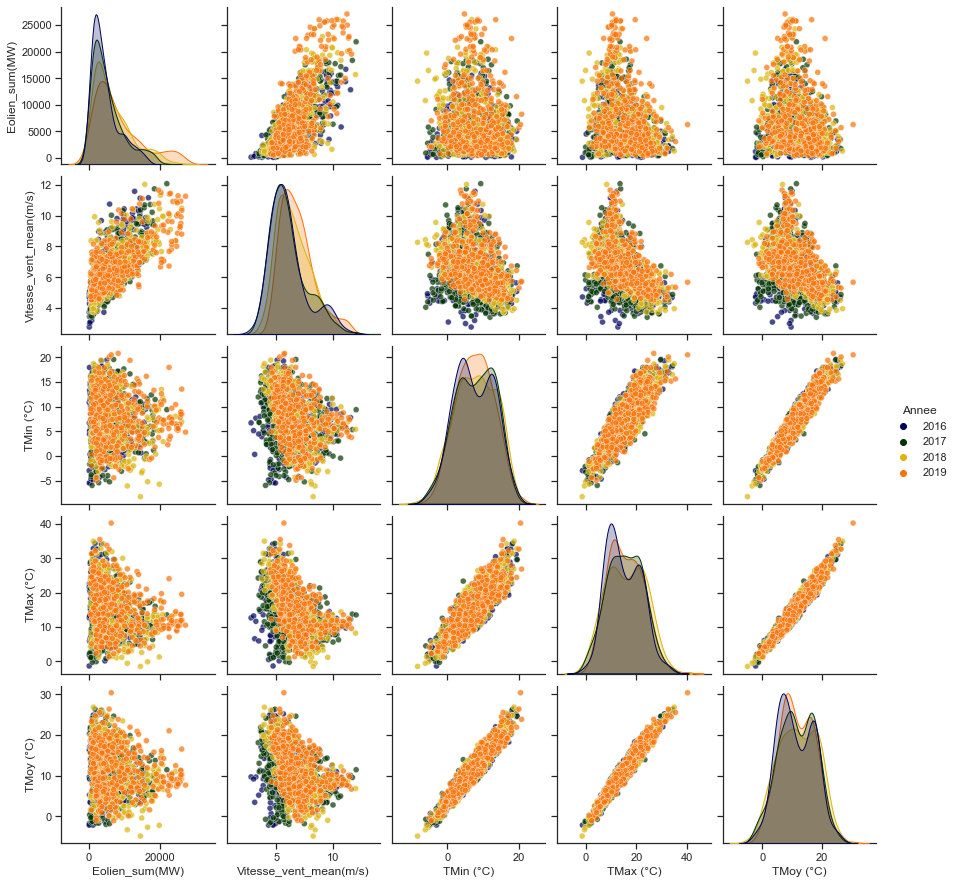

In [36]:
# on prends la région Hauts de France pour visualiser les correlations
HDF = df2016_2019.loc[(df2016_2019["Région"] == "Hauts-de-France")]
features = HDF[["Eolien_sum(MW)", "Vitesse_vent_mean(m/s)", "TMin (°C)", "TMax (°C)", "TMoy (°C)", "Annee"]]
sns.set(style="ticks", color_codes=True);
palette = sns.xkcd_palette(['dark blue', 'dark green', 'gold', 'orange'])
sns.pairplot(features, hue = 'Annee', diag_kind = 'kde', palette= palette, plot_kws=dict(alpha = 0.7),
                   diag_kws=dict(shade=True))
plt.savefig("Pictures/#10_-_Correlation_prod_eolienne_pairplot.png", dpi=150, bbox_inches='tight')
plt.show();
# les relations entre "Eolien" & les variables de temperature sont du même type
# on voit le valeurs plus élévées de production eolienne en 2019, comme déjà vu dans le graphique ci-dessus

In [37]:
# isoler une seule année, pour éliminer la difference due à l'augmentation annuelle de la production éolienne
features2019 = features.loc[(features["Annee"] == 2019)]
features2019.corr() 
# Correlation negative faible entre "Eolien" & "TMoy" (Pearson coefficient -0.17)
# Correlation positive robuste entre "Eolien" & "Vitesse du vent" (0.71)

,Eolien_sum(MW),Vitesse_vent_mean(m/s),TMin (°C),TMax (°C),TMoy (°C),Annee
Eolien_sum(MW),1.000000,0.712575,-0.015393,-0.276758,-0.172986,NaN
Vitesse_vent_mean(m/s),0.712575,1.000000,-0.284503,-0.513028,-0.433730,NaN
TMin (°C),-0.015393,-0.284503,1.000000,0.837586,0.944662,NaN
TMax (°C),-0.276758,-0.513028,0.837586,1.000000,0.970449,NaN
TMoy (°C),-0.172986,-0.433730,0.944662,0.970449,1.000000,NaN
Annee,NaN,NaN,NaN,NaN,NaN,NaN


### Production eolienne quotidien / Consommation

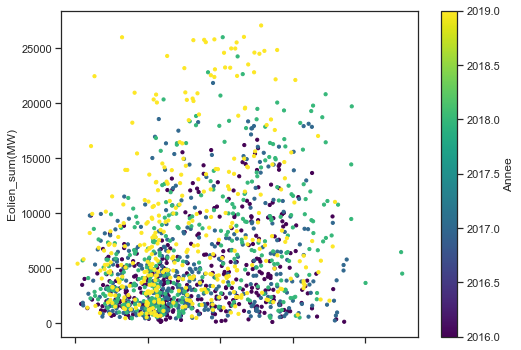

In [38]:
HDF.plot.scatter(x='Consommation-sum(MW)', y='Eolien_sum(MW)', c = 'Annee', figsize = (8,6), s=10, cmap = 'viridis')
plt.savefig("Pictures/#11_-_Correlation_prod_eolienne_conso.png", dpi=150, bbox_inches='tight')
plt.show();
# la distribution n'est pas totalement aleatoire, mais on ne voit pas de relation lineaire simple

In [39]:
# isoler une seule année, pour éliminer la difference due à l'augmentation annuelle de la production éolienne
HDF2019 = HDF.loc[(HDF["Annee"] == 2019)]
# P value & coefficient : 
pd.DataFrame(pearsonr(HDF2019['Consommation-sum(MW)'], HDF2019['Eolien_sum(MW)']), 
             index=['pearson_coeff','p-value'], columns=['resultat_test'])
# la p-value < 5% : on rejette l'hypothese que les variables sont independantes
# coefficient = 0.24, il y a une corrélation faible entre les deux variables.

,resultat_test
pearson_coeff,0.240068
p-value,0.000004


## Valeurs aberrantes / extrêmes 

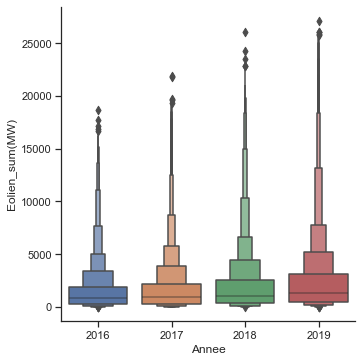

In [40]:
sns.catplot(x='Annee', y='Eolien_sum(MW)', kind='boxen', data=df2016_2019)
plt.savefig("Pictures/#12_-_Boxplot_prod_eolienne_distribution.png", dpi=150, bbox_inches='tight')
plt.show();

In [41]:
outliers2018 = df2016_2019.loc[(df2016_2019["Eolien_sum(MW)"] > 22000) & (df2016_2019["Annee"] ==2018)]
outliers2018.shape
# il y a 6 valeurs aberrantes pour l'année 2018
outliers2018.describe().round(2).head(2)
# pour ces valeurs la vitesse du vent est très au dessus de la moyenne de 5.9 pour 2016-2019
# la consommation est aussi très au-dessus de la moyenne 2016-2019 (35000) indiquant des journées de haute demande
# par consequent il s'agit probablement des vraies valeurs (pas d'erreurs)

,Annee,Month,Date,Eolien_sum(MW),Vitesse_vent_mean(m/s),Solaire_sum(MW),Rayonnement_solaire_mean(W/m2),Consommation-sum(MW),TMin (°C),TMax (°C),TMoy (°C)
count,6.0,6.0,6.00,6.00,6.00,6.0,6.00,6.00,6.00,6.00,6.00
mean,2018.0,12.0,12.33,23695.67,8.94,34.0,22.01,49238.17,7.03,12.13,9.58


In [42]:
# on va voir s'il s'agit de la même chose pour les autres années:
outliers2019 = df2016_2019.loc[(df2016_2019["Eolien_sum(MW)"] > 25000) & (df2016_2019["Annee"] ==2019)]
outliers2019.describe().round(2).head(2)
# il y a 9 valeurs extrêmes pour l'année 2019

,Annee,Month,Date,Eolien_sum(MW),Vitesse_vent_mean(m/s),Solaire_sum(MW),Rayonnement_solaire_mean(W/m2),Consommation-sum(MW),TMin (°C),TMax (°C),TMoy (°C)
count,9.0,9.00,9.00,9.00,9.00,9.00,9.00,9.00,9.0,9.00,9.00
mean,2019.0,6.56,14.11,25851.33,9.93,62.89,60.73,48916.22,8.1,12.59,10.35


In [43]:
outliers2017 = df2016_2019.loc[(df2016_2019["Eolien_sum(MW)"] > 19000) & (df2016_2019["Annee"] ==2017)]
outliers2017.describe().round(2).head(2)
# il y a 7 valeurs extrêmes pour l'année 2017

,Annee,Month,Date,Eolien_sum(MW),Vitesse_vent_mean(m/s),Solaire_sum(MW),Rayonnement_solaire_mean(W/m2),Consommation-sum(MW),TMin (°C),TMax (°C),TMoy (°C)
count,7.0,7.00,7.0,7.00,7.00,7.00,7.00,7.00,7.00,7.00,7.0
mean,2017.0,11.86,24.0,20077.57,9.14,114.57,28.26,47491.29,4.49,11.71,8.1


In [44]:
outliers2016 = df2016_2019.loc[(df2016_2019["Eolien_sum(MW)"] > 16000) & (df2016_2019["Annee"] ==2016)]
outliers2016.describe().round(2).head(2)
# il y a 10 valeurs extrêmes pour l'année 2016

,Annee,Month,Date,Eolien_sum(MW),Vitesse_vent_mean(m/s),Solaire_sum(MW),Rayonnement_solaire_mean(W/m2),Consommation-sum(MW),TMin (°C),TMax (°C),TMoy (°C)
count,10.0,10.0,10.0,10.0,10.00,10.0,10.00,10.0,10.00,10.00,10.00
mean,2016.0,3.7,18.5,16843.0,8.19,140.5,43.31,48146.3,4.51,11.52,8.02


In [45]:
# on va créer une version des données sans ces valeurs extrêmes pour utiliser ensuite dans la modelisation:
B2019 = df2016_2019.loc[(df2016_2019["Eolien_sum(MW)"] < 25000) & (df2016_2019["Annee"] ==2019)]
B2018 = df2016_2019.loc[(df2016_2019["Eolien_sum(MW)"] < 22000) & (df2016_2019["Annee"] ==2018)]
B2017 = df2016_2019.loc[(df2016_2019["Eolien_sum(MW)"] < 19000) & (df2016_2019["Annee"] ==2017)]
B2016 = df2016_2019.loc[(df2016_2019["Eolien_sum(MW)"] < 16000) & (df2016_2019["Annee"] ==2016)]
frames = [B2019, B2018, B2017, B2016]          
EolienB = pd.concat(frames)
# enregister :
EolienB.to_csv('windwithoutoutliers_2016_2019.csv', index=False)

## Visualisation de la production solaire
### Production solaire par jour en 2019

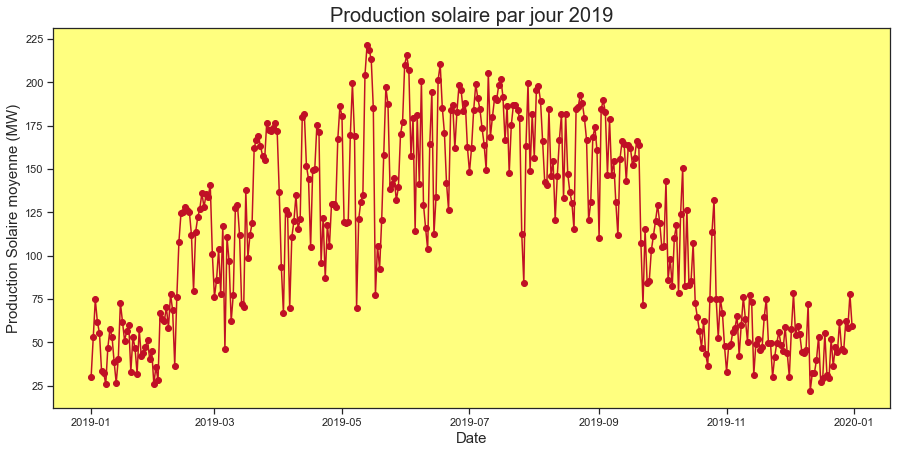

In [46]:
df_2019_mean = df_2019[["Date", "Solaire (MW)"]].groupby("Date").mean()
df_2019_mean["Date"] = df_2019_mean.index

fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(1, 1, 1)
ax.set_facecolor('#ffff7f')
dates = df_2019_mean["Date"]
values = df_2019_mean["Solaire (MW)"]
plt.plot_date(mpl.dates.date2num(dates), values, linestyle='-', color='#c01025')
plt.title('Production solaire par jour 2019', fontsize = 20)
plt.xlabel('Date', size=15)
plt.ylabel('Production Solaire moyenne (MW)', size=15)
plt.savefig("Pictures/#13_-_Production_solaire_par_jour.png", dpi=150, bbox_inches='tight')
plt.show();

# on voit une très grande variation dans la production moyenne, de >50 MW en hiver à >200 MW en été
# ces grande variations pourraient s'expliquer par les variations quotidienne du météo (jours sans soleil meme en été)

### Production solaire moyenne par région en 2019 

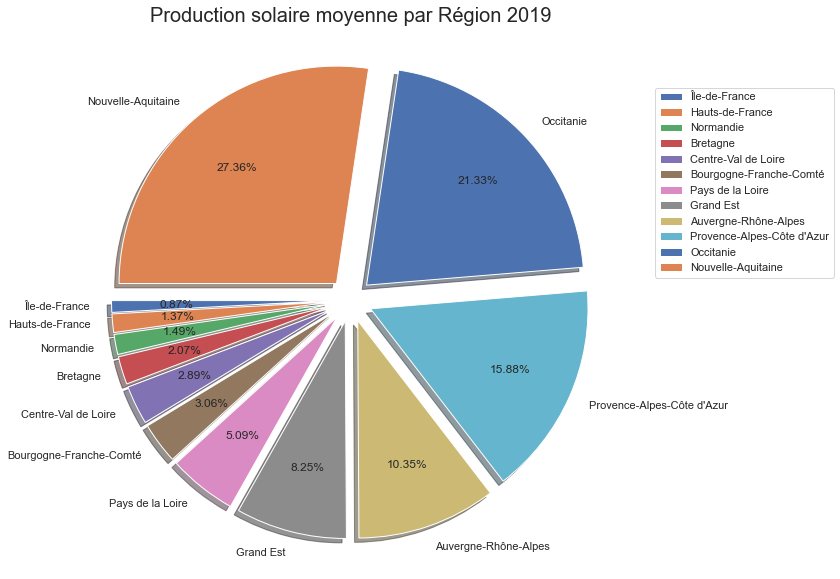

In [47]:
df_2019_region = df_2019[["Région","Solaire (MW)"]].groupby("Région").mean()
df_2019_region["Région"] = df_2019_region.index
df_2019_region.sort_values(by="Solaire (MW)",ascending=True, inplace = True)

plt.figure(figsize = (10, 10))
plt.pie(x = df_2019_region["Solaire (MW)"], labels = df_2019_region["Région"],
           explode = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,0.1, 0.1, 0.1, 0.1],
           autopct = lambda x: str(round(x, 2)) + '%',
           pctdistance = 0.7, labeldistance = 1.1, startangle=180,
           shadow = True)
plt.title('Production solaire moyenne par Région 2019', fontsize = 20)
plt.legend(bbox_to_anchor = (1.05, 0.9))
plt.savefig("Pictures/#14_-_Production_solaire_moyenne_par_region_2019.png", dpi=150, bbox_inches='tight')
plt.show();
# on voit que presque 50% de la production moyenne vient de deux régions : Nouvelle Aquitaine & Occitanie

### Production solaire par heure

<ipython-input-48-b096f01cbeac>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2019["Heure"] = df_2019["Date - Heure"].dt.time
<ipython-input-48-b096f01cbeac>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2019["Heure"] = df_2019["Heure"].astype(str)


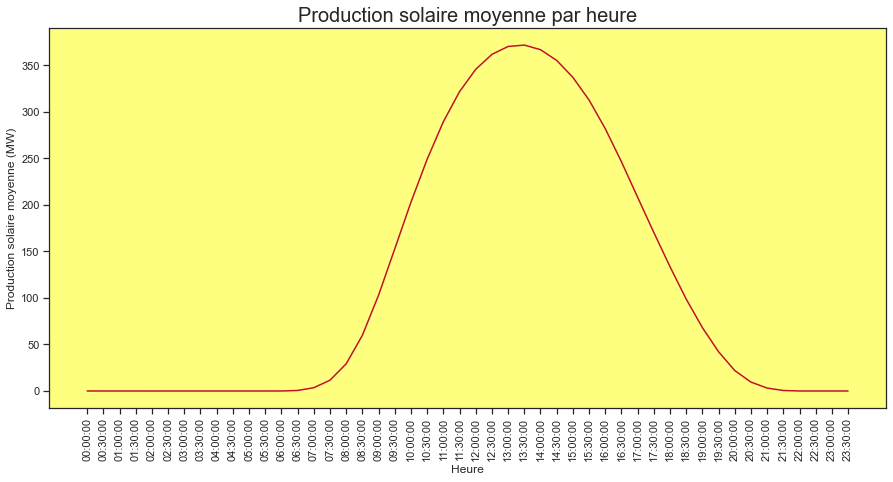

In [48]:
df_2019["Heure"] = df_2019["Date - Heure"].dt.time
df_2019["Heure"] = df_2019["Heure"].astype(str)
data_time = df_2019[["Heure", "Solaire (MW)"]].groupby("Heure").mean()
data_time["Heure"] = data_time.index

fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(1, 1, 1)
ax.set_facecolor('#ffff7f')
times = data_time["Heure"]
values = data_time["Solaire (MW)"]
plt.plot(times, values, linestyle='-', color='#c01025')
plt.title('Production solaire moyenne par heure', fontsize = 20)
plt.xlabel('Heure')
plt.xticks(rotation='vertical')
plt.ylabel('Production solaire moyenne (MW)')
plt.savefig("Pictures/#15_-_Production_solaire__par_heure_2019.png", dpi=150, bbox_inches='tight')
plt.show();
# on voit la courbe attendu, avec pic vers 13:00 et valeurs de zero pendant la nuit

### Production solaire 2015 - 2019 selon région

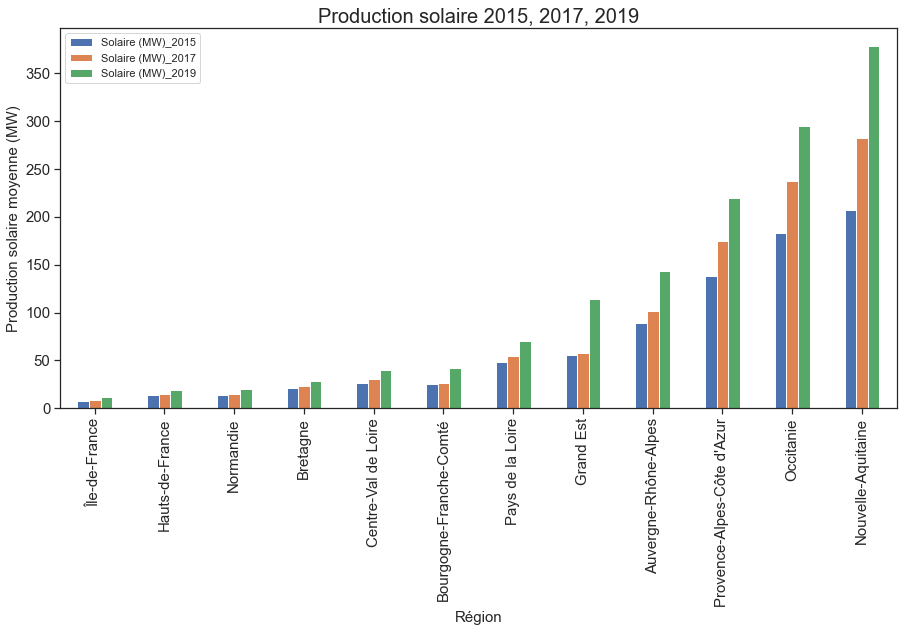

In [49]:
# groupby : Région
df_2015_region = df_2015[["Région","Solaire (MW)"]].groupby("Région").mean()
df_2017_region = df_2017[["Région","Solaire (MW)"]].groupby("Région").mean()
df_regions = df_2019_region.drop("Région", axis = 1).merge(df_2017_region["Solaire (MW)"], left_index=True, right_index=True, 
                                                           suffixes=('_2019', '_2017'))
df_regions = df_regions.merge(df_2015_region["Solaire (MW)"], left_index=True, right_index=True)
df_regions.rename(columns = {'Solaire (MW)':'Solaire (MW)_2015'}, inplace = True)

df_regions[['Solaire (MW)_2015','Solaire (MW)_2017', 'Solaire (MW)_2019']].plot(kind='bar',figsize=(15,7), fontsize=15)
plt.title("Production solaire 2015, 2017, 2019",fontsize=20)
plt.ylabel('Production solaire moyenne (MW)', size=15)
plt.xlabel('Région', size=15)
plt.savefig("Pictures/#16_-_Production_solaire_2015_2019_selon_region.png", dpi=150, bbox_inches='tight')
plt.show();
#augmentation importante de production du 2015 au 2019

### Distribution des valeurs de production solaire en 2019

In [50]:
# on prend le dataset original (avec 8 observation par jour)
data_2016_2019[["Solaire (MW)", "Rayonnement solaire global (W/m2)"]].describe().round(2)
# les distributions des variables "Solaire" & "Rayonnement solaire" sont très déséquilibrées, avec 25% ou plus des valeurs zero
# ce qui n'est pas étonnant vue le dataset contient des observations pendant la nuit
# et inclue des régions qui ont une production solaire très basse (voir graphique de production par région ci-dessus)

,Solaire (MW),Rayonnement solaire global (W/m2)
count,140676.00,140676.00
mean,95.07,153.58
std,225.02,213.84
min,-23.00,0.00
25%,0.00,0.00
50%,1.00,29.59
75%,69.00,267.34
max,2107.00,897.99


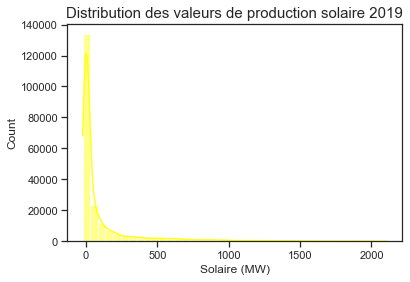

In [51]:
sns.histplot(df_2019["Solaire (MW)"], bins = 40, kde=True, color = '#ffff19')
plt.title('Distribution des valeurs de production solaire 2019', fontsize=15)
plt.savefig("Pictures/#17_-_Distribution_production_solaire_2019.png", dpi=150, bbox_inches='tight')
plt.show();
# la grande majorité des valeurs sont moins de 100 MW; quelques valeurs extrêmes jusqu'au 2100 MW

In [52]:
# on ne prend que les 4 régions plus productives (qui couvre environ 75% de la production totale)
regions = data_2016_2019.loc[(data_2016_2019["Région"] == "Nouvelle-Aquitaine") | (data_2016_2019["Région"] == "Occitanie") |
                (data_2016_2019["Région"] == "Auvergne-Rhône-Alpes") | (data_2016_2019["Région"] == "Provence-Alpes-Côte d'Azur")]
# et on exclue les valeurs negligables de la variable Rayonnement solaire
regions = regions.loc[(regions["Rayonnement solaire global (W/m2)"] > 5)]
regions.shape
# nous avons maintenant 29,564 lignes de données

(29564, 17)

In [53]:
regions[["Solaire (MW)", "Rayonnement solaire global (W/m2)"]].describe().round(2)
# après l'exclusion des valeurs < 5 de "Rayonnement solaire" & des régions moins productives 
# les distributions des variables "Solaire" & "Rayonnement solaire" sont beaucoup moins déséquilibrées

,Solaire (MW),Rayonnement solaire global (W/m2)
count,29564.00,29564.00
mean,342.08,269.41
std,383.77,238.76
min,-2.00,5.01
25%,19.00,42.85
50%,196.00,221.22
75%,560.00,429.67
max,2107.00,897.99


## Analyse des corrélations

In [54]:
# afin d'analyser les correlations, on va prendre la région plus productive, Nouvelle Aquitaine, et l'année 2019
NAQ2019 = regions.loc[(regions["Région"] == "Nouvelle-Aquitaine") & (regions["Annee"] == 2019)]

# et on groupe la production en quintiles comme fait pour la production éolienne
NAQ2019["Solar_groups"] = pd.qcut(x = NAQ2019["Solaire (MW)"], q=5,
                  labels = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5'])

<ipython-input-54-f07048f89631>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NAQ2019["Solar_groups"] = pd.qcut(x = NAQ2019["Solaire (MW)"], q=5,


In [55]:
results, bins_edges = pd.qcut(x = NAQ2019["Solaire (MW)"], q=5, retbins=True)
print(bins_edges)
# Les groupes sont : 
# -1 - 0 MW / 0 - 118 MW / 118 - 434 MW / 434 - 1184 MW / 1184 - 2107 MW

[-1.000e+00  0.000e+00  1.180e+02  4.340e+02  1.184e+03  2.107e+03]


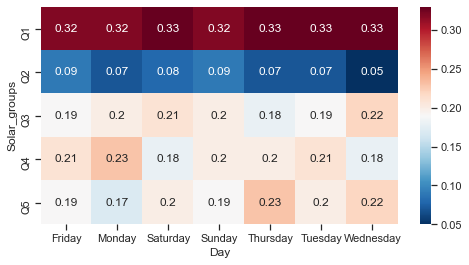

In [56]:
# Est-ce qu'il y a une difference visible entre les jours ouvrés et les weekends?
table = pd.crosstab(NAQ2019["Solar_groups"], 
           NAQ2019["Day"],  normalize = 1).round(2)
plt.figure(figsize=(8,4))
sns.heatmap(table, annot=True, cmap='RdBu_r')
plt.savefig("Pictures/#18_-_Crosstab_prodsolar_jour.png", dpi=150, bbox_inches='tight')
plt.show();
# on ne voit pas de difference entre les jours, qui peut signifier que la demande n'est pas moindre le weekend,
# ou que la production solaire n'est pas ajustée selon la demande, qui semble logique, compte tenu du bas niveau de production

In [57]:
# test χ2 pour confirmer si ces 2 variables sont indépendantes
table = pd.crosstab(NAQ2019["Solar_groups"], 
           NAQ2019["Day"])
resultats_test = chi2_contingency(table)
statistique = resultats_test[0]
p_valeur = resultats_test[1]
degre_liberte = resultats_test[2]
print(statistique, p_valeur,degre_liberte)
# p-value > 5% donc l'hypothèse "les variables sont indépendantes" n'est pas réjétée

11.631906036520336 0.9837456369973574 24


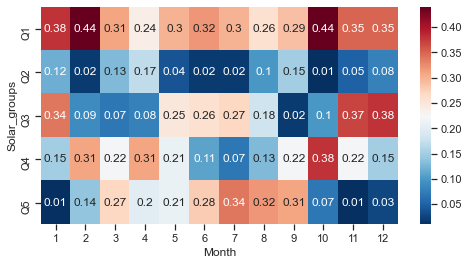

In [58]:
# Est-ce qu'il y a une difference visible entre les mois?
table2 = pd.crosstab(NAQ2019["Solar_groups"], 
           NAQ2019["Month"],  normalize = 1).round(2)
plt.figure(figsize=(8,4))
sns.heatmap(table2, annot=True, cmap='RdBu_r')
plt.savefig("Pictures/#19_-_Crosstab_prodsolar_mois.png", dpi=150, bbox_inches='tight')
plt.show();
# Comme attendu, ici les differences sont claires : 
# en été ~30% des valeurs sont Q5 / par contre, entre oct & fev il y a peu de valeurs en Q5
# il y a beaucoup de valeurs Q1 pour tous les mois qui correspondraient aux valeurs basse du rayonnement solaire tôt le matin, et le soir

In [59]:
# on fait le test χ2 pour les variables Month & Solar Groups:
table2 = pd.crosstab(NAQ2019["Solar_groups"], 
           NAQ2019["Month"])
resultats_test2 = chi2_contingency(table2)
statistique2 = resultats_test2[0]
p_valeur2 = resultats_test2[1]
degre_liberte2 = resultats_test2[2]
print(statistique2, p_valeur2,degre_liberte2)
# p-value zero, donc on rejette l'hypothèse "les variables sont indépendantes"

476.97711644216423 4.831144688200604e-74 44


In [60]:
# on va mesurer le niveau de corrélation (V Cramer)
X2 = stats.chi2_contingency(table2)[0]
n = np.sum(table2)
minDim = min(table2.shape)-1
V = np.sqrt((X2/n) / minDim)
print(V.mean())
# V Cramer 0.83 indique une correlation significative

0.8322581716471559


C:\Users\verre\anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


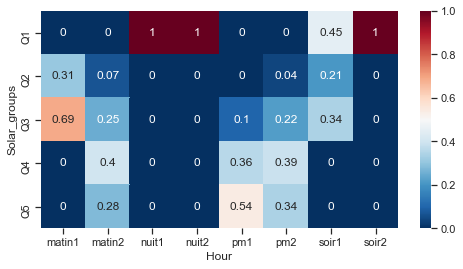

In [61]:
# une correlation entre l'heure et la production solaire est évidente, mais on va le confirmer:
NAQ2019.replace({'Hour': {1: "nuit1", 2:"nuit1", 4: "nuit2", 5: "nuit2", 7: "matin1", 8:"matin1", 
                           10: "matin2", 11:"matin2", 13: "pm1", 14:"pm1", 16: "pm2", 17:"pm2", 
                           19: "soir1", 20:"soir1", 22: "soir2", 23:"soir2"}}, inplace = True)
table3 = pd.crosstab(NAQ2019['Solar_groups'], 
            NAQ2019['Hour'],  normalize = 1).round(2)
plt.figure(figsize=(8,4))
sns.heatmap(table3, annot=True, cmap='RdBu_r')
plt.savefig("Pictures/#20_-_Crosstab_prodsolar_heure.png", dpi=150, bbox_inches='tight')
plt.show();

In [62]:
# Comme attendu, la nuit 100% des valeurs sont Q1, l'après-midi majoritairement Q4 & Q5

### Production solaire  / temperature, vitesse du vent, rayonnement solaire

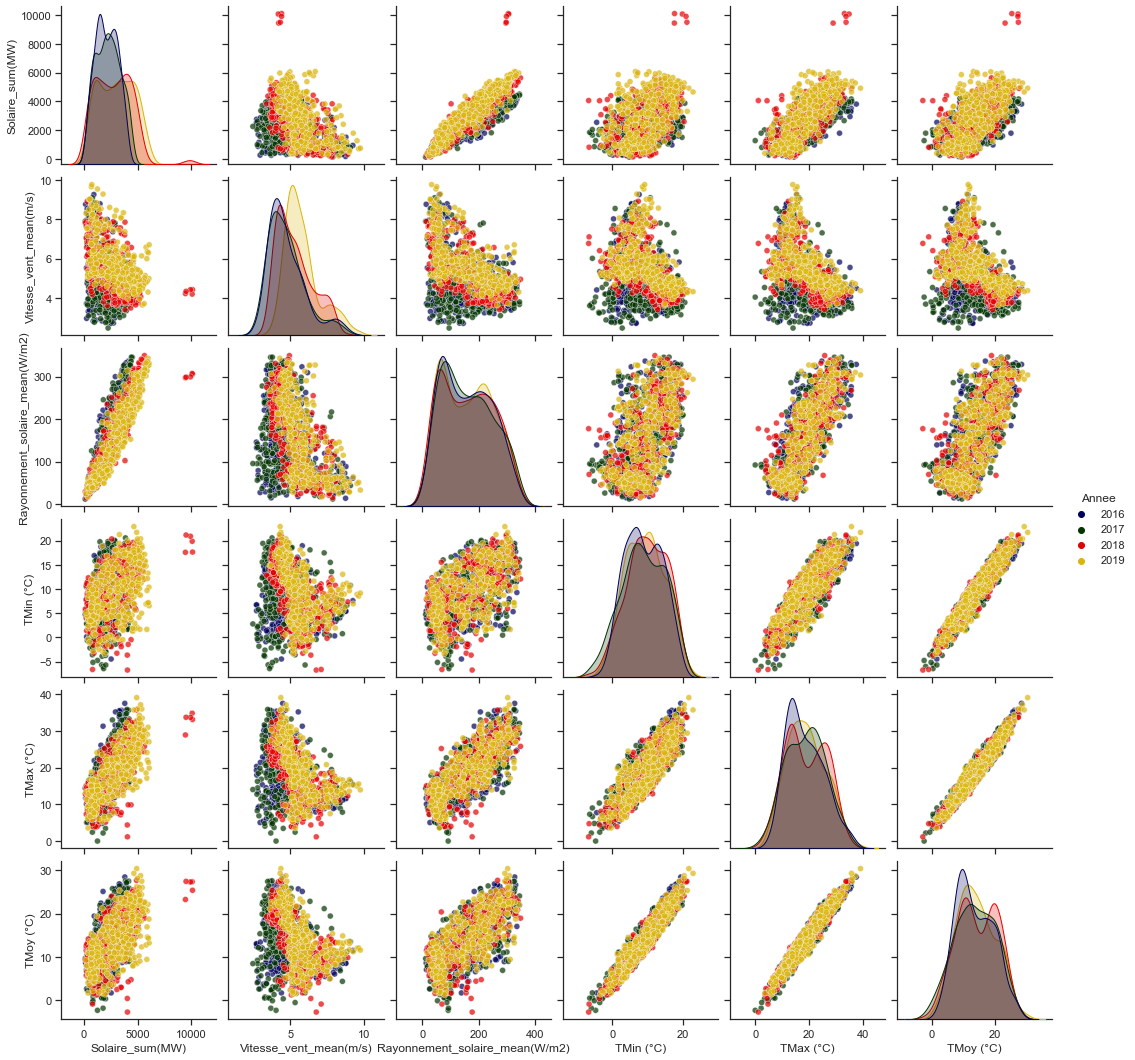

In [63]:
# Avant de regarder les correlations, on va isoler la région Nouvelle Aquitaine
NAQ = df2016_2019.loc[(df2016_2019["Région"] == "Nouvelle-Aquitaine")]
features = NAQ[["Solaire_sum(MW)", "Vitesse_vent_mean(m/s)", "Rayonnement_solaire_mean(W/m2)", 
                "TMin (°C)", "TMax (°C)", "TMoy (°C)", "Annee"]]
sns.set(style="ticks", color_codes=True);
palette = sns.xkcd_palette(['dark blue', 'dark green', 'red', 'gold'])
sns.pairplot(features, hue = 'Annee', diag_kind = 'kde', palette= palette, plot_kws=dict(alpha = 0.7),
                   diag_kws=dict(shade=True))
plt.savefig("Pictures/#21_-_Pairplot_prodsolar_correlations.png", dpi=150, bbox_inches='tight')
plt.show();
# la relation entre "Solaire_sum" & "Rayonnement solaire_mean" est clairement lineaire, 
# mais pour "Solaire_sum" & les variables de temperature ce n'est pas si claire
# on note le valeurs très aberrantes de la production solaire en 2018

In [64]:
# isoler une seule année, pour éliminer la difference due à l'augmentation annuelle de la production solaire
features2019 = features.loc[(features["Annee"] == 2019)]
features2019.corr().round(2)
# Correlation negative robuste entre "Solaire_sum" & "Vitesse_vent_mean" (Pearson coefficient -0.57)
# Correlation positive très forte entre "Solaire_sum" & "Rayonnement_solaire_mean" (0.94)
# Correlation positive robuste entre "Solaire_sum" & les variables de temperature, surtout "TMax" (0.76)

,Solaire_sum(MW),Vitesse_vent_mean(m/s),Rayonnement_solaire_mean(W/m2),TMin (°C),TMax (°C),TMoy (°C),Annee
Solaire_sum(MW),1.00,-0.57,0.94,0.42,0.76,0.64,NaN
Vitesse_vent_mean(m/s),-0.57,1.00,-0.62,-0.37,-0.53,-0.48,NaN
Rayonnement_solaire_mean(W/m2),0.94,-0.62,1.00,0.55,0.80,0.72,NaN
TMin (°C),0.42,-0.37,0.55,1.00,0.84,0.95,NaN
TMax (°C),0.76,-0.53,0.80,0.84,1.00,0.97,NaN
TMoy (°C),0.64,-0.48,0.72,0.95,0.97,1.00,NaN
Annee,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Production solaire quotidien / Consommation

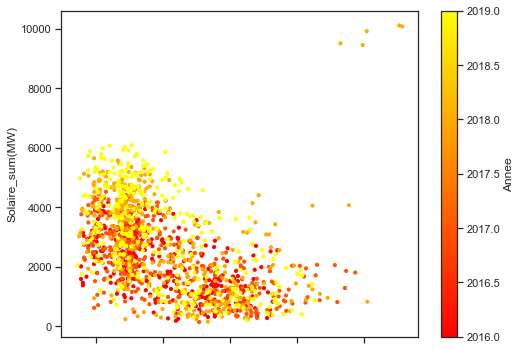

In [77]:
NAQ.plot.scatter(x='Consommation-sum(MW)', y='Solaire_sum(MW)', c = 'Annee', figsize = (8,6), s=10, cmap = 'autumn')
plt.savefig("Pictures/#22_-_Correlation_prod_solaire_conso.png", dpi=150, bbox_inches='tight')
plt.show();
# les valeurs élévées de production solaire correspondent généralement aux valeurs plûtot basses de la consommation,
# qui pourrait s'expliquer par la production solaire élévée en été, quand on peut s'attendre un niveau de consommation plus bas
# L'augmentation de production solaire du 2016 au 2019 est bien visible

In [67]:
# isoler une seule année, pour éliminer la difference due à l'augmentation annuelle de la production solaire
NAQ2019 = NAQ.loc[(NAQ["Annee"] == 2019)]
# P value & coefficient : 
pd.DataFrame(pearsonr(NAQ2019['Consommation-sum(MW)'], NAQ2019['Solaire_sum(MW)']), 
             index=['pearson_coeff','p-value'], columns=['resultat_test'])
# la p-value < 5% : on rejette l'hypothese que les variables sont independantes
# coefficient = -0.59, il y a une corrélation negative robuste entre les deux variables.

,resultat_test
pearson_coeff,-5.924508e-01
p-value,5.881992e-36


## Valeurs extrêmes

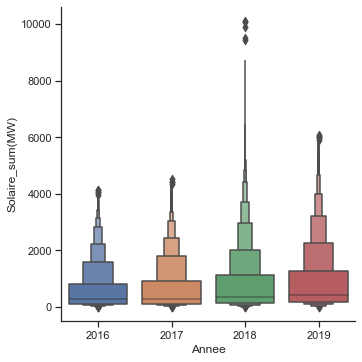

In [74]:
#Analyse des valeurs extrêmes de la production solaire
sns.catplot(x='Annee', y='Solaire_sum(MW)', kind='boxen', data=df2016_2019)
plt.savefig("Pictures/#23_-_Boxplot_prod_solaire.png", dpi=150, bbox_inches='tight')
plt.show();
# On constate des valeurs aberrantes en 2018 

In [72]:
outliers = df2016_2019.loc[ (df2016_2019["Solaire_sum(MW)"] > 9000)]
outliers.describe().round(2).head(2)
# il y a 5 valeurs aberrantes ( > 9000 MW)

,Annee,Month,Date,Eolien_sum(MW),Vitesse_vent_mean(m/s),Solaire_sum(MW),Rayonnement_solaire_mean(W/m2),Consommation-sum(MW),TMin (°C),TMax (°C),TMoy (°C)
count,5.0,5.0,5.0,5.0,5.00,5.0,5.00,5.0,5.00,5.00,5.00
mean,2018.0,8.0,3.0,2135.0,4.32,9808.6,301.45,71518.2,19.43,32.89,26.16


In [73]:
# on va comparer les statistiques ci-dessus avec ceux de l'ensemble de données : 
df2016_2019[["Eolien_sum(MW)", "Rayonnement_solaire_mean(W/m2)", "TMin (°C)", "TMax (°C)", "TMoy (°C)"] ].describe().round(2)
# les valeurs aberrantes ci-dessus ont un rayonnement solaire moyenne loin au-dessus de la moyenne de 153 pour 
# l'ensemble de données et la temperature max associée est aussi très élévée
# Par consequent il peut s'agir des vraies valeurs extrêmes et non des erreurs

,Eolien_sum(MW),Rayonnement_solaire_mean(W/m2),TMin (°C),TMax (°C),TMoy (°C)
count,17532.00,17532.00,17532.00,17532.00,17532.00
mean,2036.70,153.08,8.13,17.43,12.78
std,3026.77,91.16,5.86,7.75,6.57
min,0.00,4.85,-11.98,-3.75,-6.48
25%,341.00,68.80,3.72,11.48,7.81
50%,1009.50,144.59,8.10,16.90,12.24
75%,2427.25,228.96,12.70,23.25,17.90
max,27094.00,350.11,23.72,41.68,32.70


In [75]:
# on crée une version des données sans ces valeurs
SolarB = df2016_2019.loc[(df2016_2019["Solaire_sum(MW)"] < 9000)]
SolarB.shape

(17527, 13)

In [76]:
# enregister :
SolarB.to_csv('solarwithoutoutliers_2016_2019.csv', index=False)